In [124]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pp

def get_wave(periods: float, freq:float, xshift: float, yshift: float, ystretch: float, res: int = 1_000):
    '''
    Creates a trigonometric wave function. Given the parameters 
        periods  = 1
        freq     = 1
        xshift   = 0
        yshift   = 0
        ystretch = 1
    one would get a vanilla sine function.
    
    
    Parameters
    ----------
    periods: float
        the amount of periods the wave function should have
        
    freq: float
        the amount of periods within 2*np.pi, freq has to be strictly positive

    xshift: float
        the shift of the vanilla wave function across the x-axis
        
    yshift: float
        the shift of the vanilla wave function across the y-axis
        
    ystretch: float
        the stretch factor across y-axis of a vanilla sine-wave with [-1,1] range, applying
        some factor y_s gives [-y_s, y_s] range
        
    res: float, optional
        determines at what resolution the timeseries is being built 

    '''
    if freq <= 0:
        raise Exception("freq must be strictly positive")
    
    # create arguments for the sine function where
    #   xshift  - shifts the points along the x-axis
    #   periods - determines how often a periods is being produced
    #   res     - determines how many points are being produced over the
    #             given parameters
    points = np.linspace(0 + xshift, periods * 2* np.pi + xshift, res)
    
    # compute the sine values stretching them with `ystretch` and shift them with `yshift`
    y = np.sin(points) * ystretch + yshift 
    
    # computing the arguments range, such that the are scaled correctly
    x = (np.arange(0,res)/res)*2*np.pi*periods/freq
    return np.asarray((x,y))

def get_rect(periods: float, freq:float, xshift: float, yshift: float, ystretch: float, saturation_factor: float, res: float = 1000):
    '''
    Creates a trigonometric wave function. Contrary to the `get_wave` function it will "saturate"
    the wave function, such that it hard-clips it at some factor `sat_fac` 0 <= sat_fac <= 1. Creates a trigonometric wave function. Given the parameters 
        periods = 1
        xshift = 0
        yshift = 0
        ystretch = 1
    one would get a vanilla sine function.
    
    
    Parameters
    ----------
    periods: float
        gives the amount of periods the wave function should have
        
    freq: float
        the amount of periods within 2*np.pi

    xshift: float
        the shift of the vanilla wave function across the x-axis
        
    yshift: float
        the shift of the vanilla wave function across the y-axis
        
    ystretch: float
        the stretch factor across y-axis of a vanilla sine-wave with [-1,1] range, applying
        some factor y_s gives [-y_s, y_s] range
        
    saturation_factor: float
        the factor how much a sine function is being hard clipped creating a rectangle-similar function, the factor is supposed to be in the range [0,1] where 0 is no saturation at all and 1 clipping completely creating a straight line
        
    res: float, optional
        determines at what resolution the timeseries is being built 
    '''
    if saturation_factor > 1 or saturation_factor < 0:
        raise Exception("saturation_factor is supposed to be in the range [0,1]")
    data = get_wave(periods, freq, xshift, yshift, ystretch, res)
    
    # determine max and min points of the wave
    max_pt = np.max(data[1])
    min_pt = np.min(data[1])
    
    # determine wave vertical length
    v_length = np.abs(max_pt - min_pt)
    
    # determine hard-clip points relative to max and min points
    sat_max_pt = (min_pt + max_pt)/2 + v_length*saturation_factor
    sat_min_pt = (min_pt + max_pt)/2 - v_length*saturation_factor
    
    # mask out the points outside of the clipping range
    mask_top = data[1] <= sat_max_pt
    mask_bottom = data[1] >= sat_min_pt
    clipped = np.where(mask_top, data[1], sat_max_pt)
    clipped = np.where(mask_bottom, clipped, sat_min_pt)

    # reassign wave and output
    data[1] = clipped
    return data

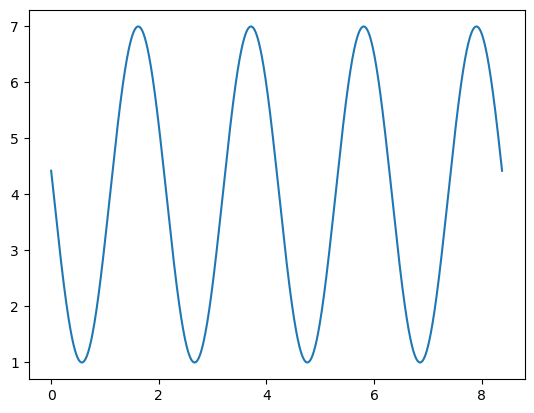

In [6]:
# Testing wave functions and see a plot

x,y = get_wave(periods=4, 
               freq=3,
               xshift=3, 
               yshift=4, 
               ystretch=3,
               res=10000)
plt.plot(x, y)

In [7]:
def create_dataset(n: int, seed: int=1337, res: int=10_000):
    """
    Creates a dataset of vanilla sine waves and clipped sine waves which we will refer to rectangle functions,
    though they are not precisely rectangle functions 
    
    Parameters
    ----------
    n: int
        number of samples generated for each class, which are
        0 - sine waves
        1 - rectangle waves
        
    seed: int
        random seed
    
    res: int
        number of samples created
    """
    np.random.seed(seed)
    waves = []
    rects = []
    for _ in range(n):
        periods  = np.random.randint(1_000)/100
        xshift   = np.random.randint(1_000)/100
        yshift   = np.random.randint(1_000)/100
        freq     = np.random.randint(1, 1_000)/800
        ystretch = np.random.randint(1_000)/100
        wave     = get_wave(periods=periods, 
                            xshift=xshift, 
                            yshift=yshift, 
                            freq=freq, 
                            ystretch=ystretch,
                            res=res)
        waves.append(wave)

    for _ in range(n):
        periods  = np.random.randint(1_000)/100
        xshift   = np.random.randint(1_000)/100
        yshift   = np.random.randint(1_000)/100
        freq     = np.random.randint(1, 1_000)/800
        ystretch = np.random.randint(1_000)/100
        sat      = np.random.randint(400)/1_000
        rect   = get_rect(periods=periods,
                          xshift=xshift, 
                          yshift=yshift, 
                          freq=freq, 
                          ystretch=ystretch,
                          saturation_factor=sat,
                          res=res)
        rects.append(rect)
    return waves, rects
    

data = create_dataset(100)

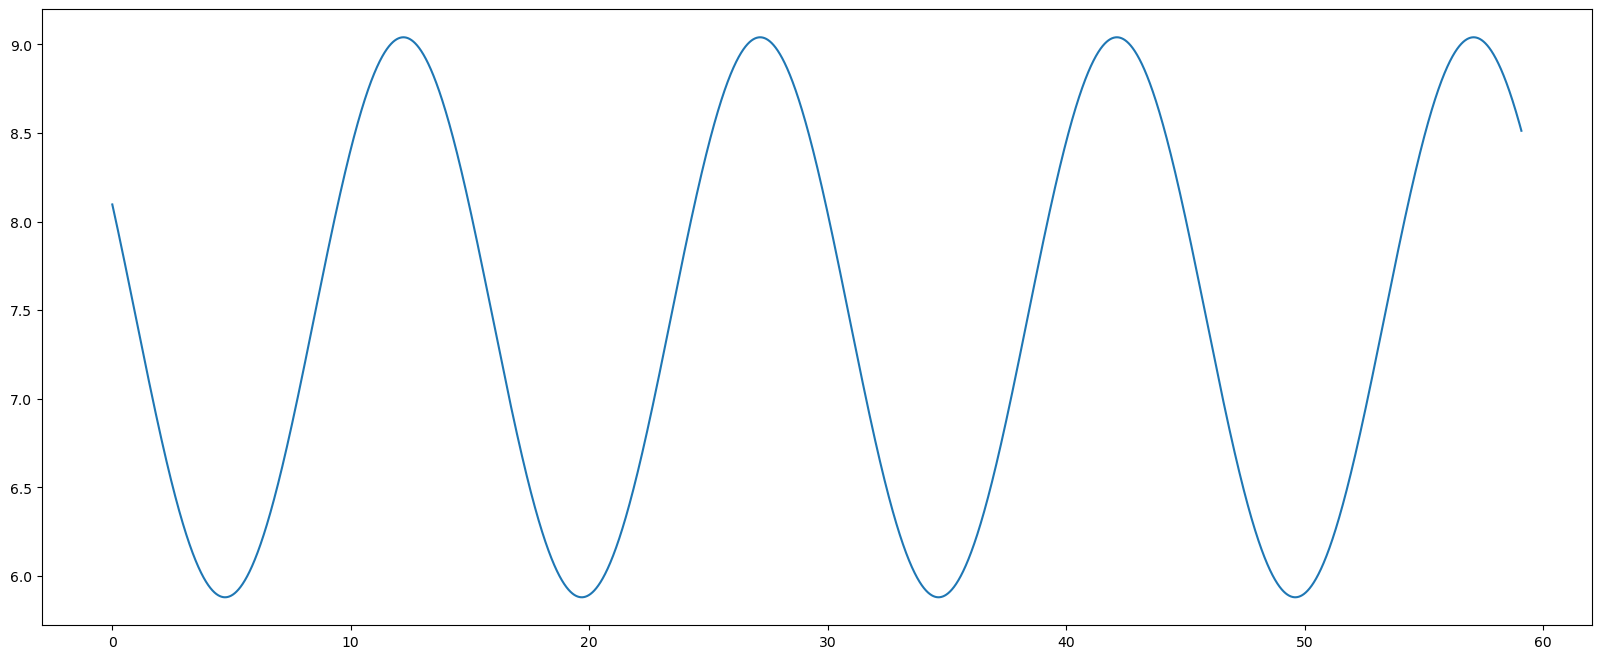

In [8]:
sample = 33
x=data[0][sample][0]
y=data[0][sample][1]

plt.figure(figsize=(20,8))
plt.plot(x,y)

In [9]:
np.fft.rfft(data[1][sample][1])

array([ 2.94049627e+04+0.00000000e+00j,  7.64178884e+01-9.14416503e+02j,
       -5.15592945e+00-2.86394887e+02j, ...,
        1.77515438e-01-1.10385572e-04j,  1.77521575e-01-2.67400135e-05j,
        1.77518086e-01+0.00000000e+00j])

In [11]:
from scipy.fft import fft, ifft, rfft 

Y = rfft(data[1][sample][1])
N = len(Y)

# Generate the exponential form representation

formula = "DFT Coefficients:\n\n"
for k in range(N):
    if k == 0:
        formula += f"DC Component: {Y[k].real:.2f}\n"
    elif k == N - 1:
        formula += f"Nyquist Frequency Component: {Y[k].real:.2f}\n"
    else:
        formula += f"Frequency Component at {k} Hz: {Y[k].real:.2f} * exp(-i2pi * {k} * t / N) + {Y[k].imag:.2f} * exp(i2pi * {k} * t / N)\n"

print(formula)

DFT Coefficients:

DC Component: 29404.96
Frequency Component at 1 Hz: 76.42 * exp(-i2pi * 1 * t / N) + -914.42 * exp(i2pi * 1 * t / N)
Frequency Component at 2 Hz: -5.16 * exp(-i2pi * 2 * t / N) + -286.39 * exp(i2pi * 2 * t / N)
Frequency Component at 3 Hz: -19.63 * exp(-i2pi * 3 * t / N) + -154.12 * exp(i2pi * 3 * t / N)
Frequency Component at 4 Hz: 0.76 * exp(-i2pi * 4 * t / N) + -139.47 * exp(i2pi * 4 * t / N)
Frequency Component at 5 Hz: 10.94 * exp(-i2pi * 5 * t / N) + -122.30 * exp(i2pi * 5 * t / N)
Frequency Component at 6 Hz: 0.40 * exp(-i2pi * 6 * t / N) + -95.14 * exp(i2pi * 6 * t / N)
Frequency Component at 7 Hz: -6.56 * exp(-i2pi * 7 * t / N) + -78.07 * exp(i2pi * 7 * t / N)
Frequency Component at 8 Hz: -0.25 * exp(-i2pi * 8 * t / N) + -70.13 * exp(i2pi * 8 * t / N)
Frequency Component at 9 Hz: 4.54 * exp(-i2pi * 9 * t / N) + -62.94 * exp(i2pi * 9 * t / N)
Frequency Component at 10 Hz: 0.63 * exp(-i2pi * 10 * t / N) + -56.70 * exp(i2pi * 10 * t / N)
Frequency Component at 

In [133]:
x,y = get_wave(1,1,0,0,1,10)

[('0.0', '0.0'),
 ('0.6283185307179586', '0.6427876096865393'),
 ('1.2566370614359172', '0.984807753012208'),
 ('1.8849555921538759', '0.8660254037844387'),
 ('2.5132741228718345', '0.3420201433256689'),
 ('3.141592653589793', '-0.34202014332566866'),
 ('3.7699111843077517', '-0.8660254037844384'),
 ('4.39822971502571', '-0.9848077530122081'),
 ('5.026548245743669', '-0.6427876096865396'),
 ('5.654866776461628', '-2.4492935982947064e-16')]


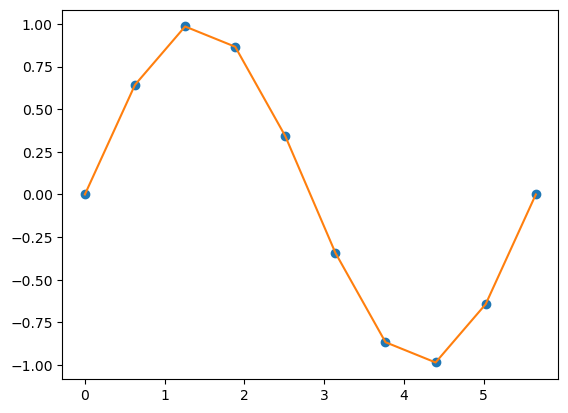

In [144]:
plt.plot(x, y, 'o')
plt.plot(x,y)

pp([(str(_x),str(_y)) for _x,_y in zip(x,y)])

In [160]:
def F_n(Y):
    n = len(Y)
    Y_hat = []
    for k in range(len(Y)):
        transformed_k = 1/n * sum([y_l * np.exp(-2 * np.pi * 1j* k * l/n) for l, y_l in enumerate(Y) ])
        Y_hat.append(transformed_k)
    return Y_hat

Y_hat = F_n(y)
pp([str(_y) for _y in Y_hat])
pp([str(_y) for _y in np.fft.fft(y)])

['(-1.33907057366955e-17+0j)',
 '(0.14283712054380923-0.439607454395199j)',
 '(-0.048591754799448425+0.06688081278992913j)',
 '(-0.039133572999081954+0.028432205056635337j)',
 '(-0.036913281031968816+0.01199385205986717j)',
 '(-0.036397023426620205-2.0058074207055733e-17j)',
 '(-0.03691328103196878-0.011993852059867215j)',
 '(-0.03913357299908168-0.028432205056635646j)',
 '(-0.04859175479944824-0.06688081278992904j)',
 '(0.1428371205438091+0.439607454395199j)']
['(-1.1102230246251565e-16+0j)',
 '(1.428371205438092-4.39607454395199j)',
 '(-0.4859175479944836+0.6688081278992911j)',
 '(-0.3913357299908192+0.2843220505663533j)',
 '(-0.36913281031968803+0.11993852059867194j)',
 '(-0.36397023426620184-1.1102230246251565e-16j)',
 '(-0.36913281031968803-0.11993852059867194j)',
 '(-0.3913357299908196-0.2843220505663534j)',
 '(-0.4859175479944836-0.6688081278992911j)',
 '(1.4283712054380922+4.39607454395199j)']


In [146]:
from pprint import pp

def F_n_inv(Y_hat):
    n = len(Y_hat)
    Y = []
    for k in range(len(Y_hat)):
        transformed_k =sum([y_l * np.exp(2 * np.pi * 1j* k * l/n) for l, y_l in enumerate(Y_hat) ])
        Y.append(transformed_k)

    return Y

Y_back = np.real(F_n_inv(Y_hat))

In [164]:
def trig_interpolation(Y_hat, x_range, depth=1000):
    n = len(Y_hat)

    get_summand = lambda c_j,l,x: c_j*np.exp(2 * np.pi * 1j * l*x)

    y_intp = []
    x_intp = list((i/depth)*x_range for i in range(depth))
    if n%2==0:
        K = n//2 
        for x in x_intp:
            y_intp.append(sum([get_summand(c_j,l,x) for l,c_j in zip(range(-K+1,K+1), Y_hat)]))
    else:
        K = n//2+1
        for x in x_intp:
            y_intp.append(sum([get_summand(c_j,l,x) for l,c_j in zip(range(-K,K+1), Y_hat)]))

    return x_intp, y_intp

x_range = max(x)-min(x)
x_intp, y_intp = trig_interpolation(Y_hat, x_range)

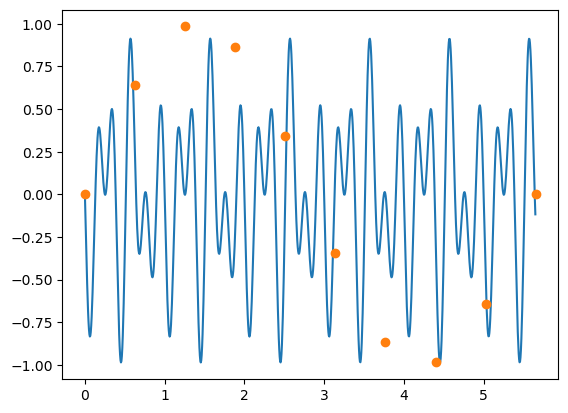

In [165]:
plt.plot(x_intp,np.real(y_intp))
plt.plot(x,y, 'o')